<a href="https://colab.research.google.com/github/ValeeRon/MyLabs/blob/master/Diplom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

python version==3.7.10
pandas==1.1.5
numpy==1.19.5
sklearn==0.22.2.post1
torch==1.8.0+cu101
matplotlib==3.2.2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:210: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


Epoch 1 Train loss: 0.38. Validation loss: 0.25. Avg future: 0.00. Elapsed time: 16.22s.
Epoch 2 Train loss: 0.08. Validation loss: 0.07. Avg future: 0.00. Elapsed time: 15.14s.
Epoch 3 Train loss: 0.08. Validation loss: 0.03. Avg future: 0.00. Elapsed time: 14.96s.
Epoch 4 Train loss: 0.05. Validation loss: 0.02. Avg future: 0.00. Elapsed time: 15.16s.
Epoch 5 Train loss: 0.03. Validation loss: 0.01. Avg future: 0.00. Elapsed time: 15.94s.
Epoch 6 Train loss: 0.04. Validation loss: 0.01. Avg future: 0.00. Elapsed time: 17.08s.
Epoch 7 Train loss: 0.02. Validation loss: 0.01. Avg future: 0.00. Elapsed time: 17.23s.
Epoch 8 Train loss: 0.02. Validation loss: 0.01. Avg future: 0.00. Elapsed time: 15.04s.
Epoch 9 Train loss: 0.01. Validation loss: 0.01. Avg future: 0.00. Elapsed time: 15.22s.
Epoch 10 Train loss: 0.01. Validation loss: 0.01. Avg future: 0.00. Elapsed time: 15.11s.
Epoch 11 Train loss: 0.01. Validation loss: 0.01. Avg future: 0.00. Elapsed time: 15.04s.
Epoch 12 Train loss

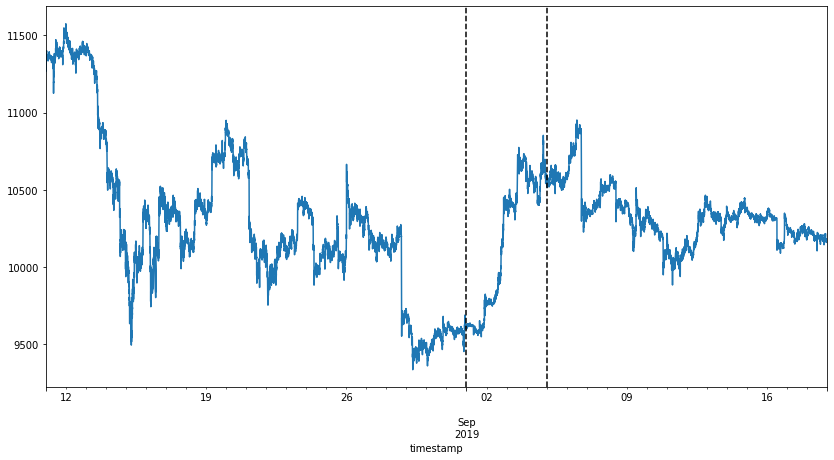

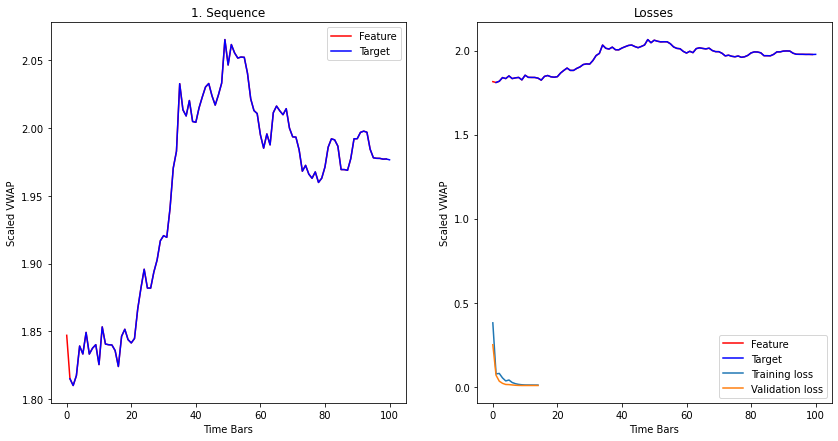

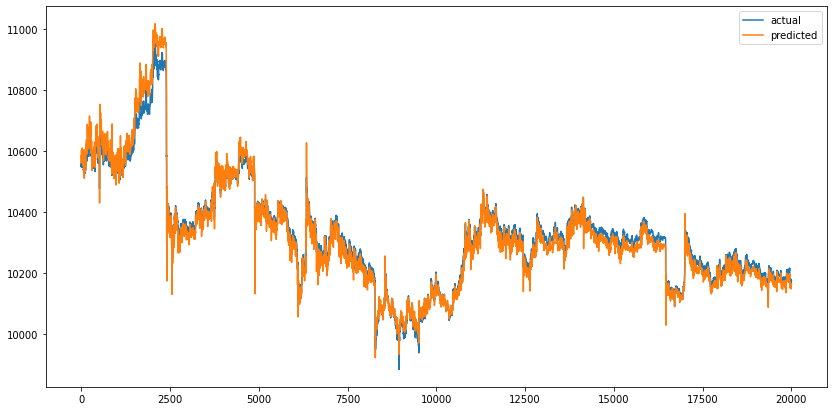

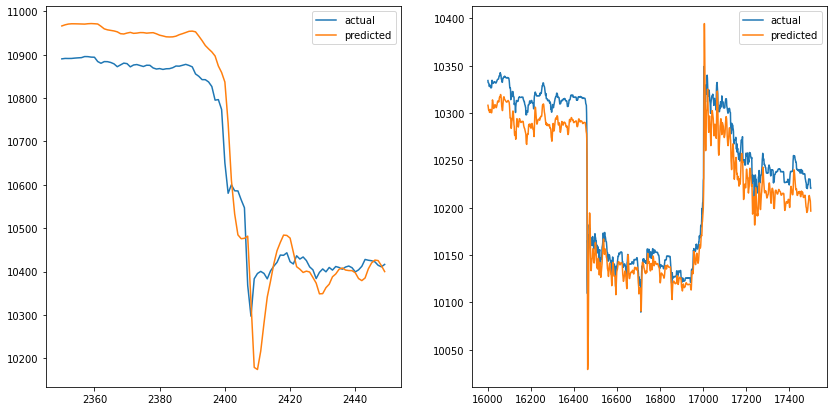

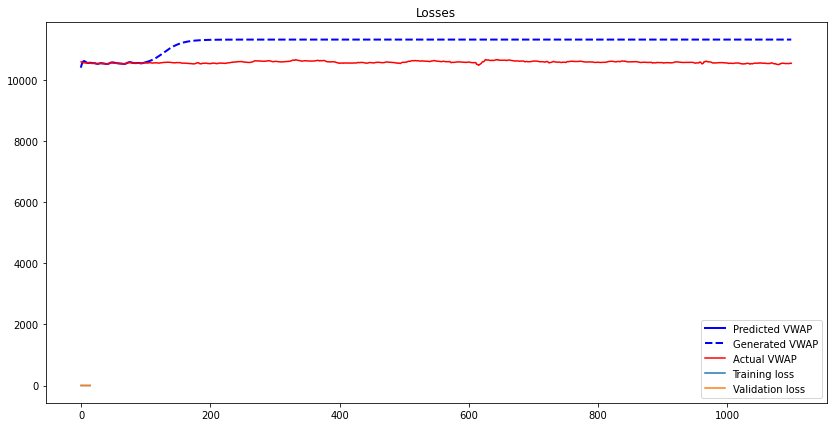

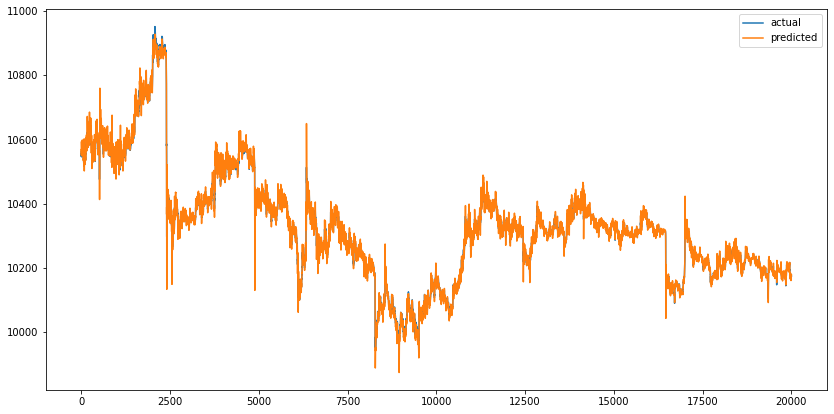

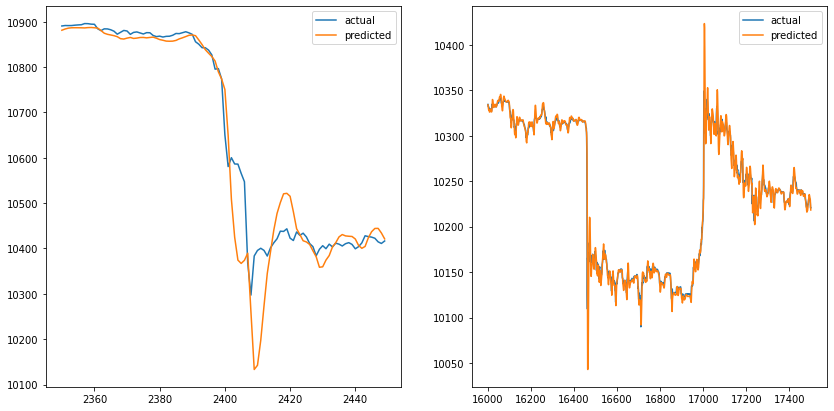

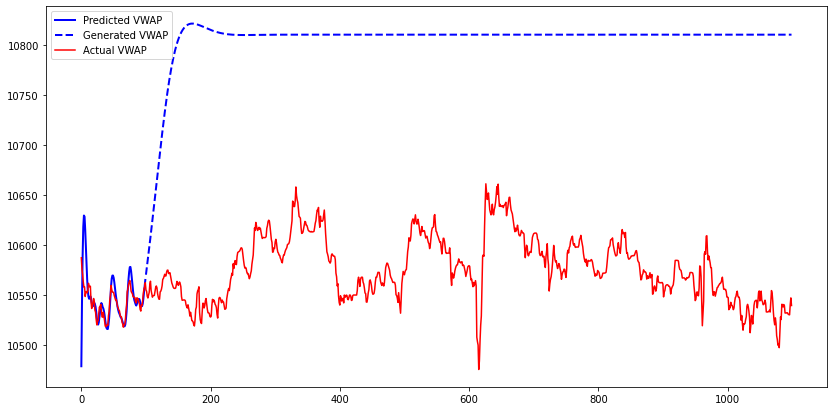

In [ ]:
%matplotlib inline

import glob
from platform import python_version
import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import time
import random

def transform_data(arr, seq_len):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + 1 : i + seq_len + 1]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y).reshape(-1, seq_len)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var

def plot_sequence(axes, i, x_train, y_train):
    axes[i].set_title("%d. Sequence" % (i + 1))
    axes[i].set_xlabel("Time Bars")
    axes[i].set_ylabel("Scaled VWAP")
    axes[i].plot(range(seq_len), x_train[i].cpu().numpy(), color="r", label="Feature")
    axes[i].plot(range(1, seq_len + 1), y_train[i].cpu().numpy(), color="b", label="Target")
    axes[i].legend()

class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, future=0, y=None):
        outputs = []

        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]

        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

class Optimization:
    """ A helper class to train, test and diagnose the LSTM"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            yield x_batch, y_batch, batch

    def train(
        self,
        x_train,
        y_train,
        x_val=None,
        y_val=None,
        batch_size=100,
        n_epochs=15,
        do_teacher_forcing=None,
    ):
        seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []

            train_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
                y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.scheduler.step()
            train_loss /= batch
            self.train_losses.append(train_loss)

            self._validation(x_val, y_val, batch_size)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )

    def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len) / 2)
            limit = x_batch.size(1) - future
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            future = 0
            y_pred = self.model(x_batch)
        self.futures.append(future)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= batch
            self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                y_pred = (
                    y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                )
                loss = self.loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
            test_loss /= batch
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
def generate_sequence(scaler, model, x_sample, future=1000):
    """ Generate future values for x_sample with the model """
    y_pred_tensor = model(x_sample, future=future)
    y_pred = y_pred_tensor.cpu().tolist()
    y_pred = scaler.inverse_transform(y_pred)
    return y_pred
def to_dataframe(actual, predicted):
    return pd.DataFrame({"actual": actual, "predicted": predicted})


def inverse_transform(scalar, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df

print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("sklearn==%s" % sklearn.__version__)
print("torch==%s" % torch.__version__)
print("matplotlib==%s" % matplotlib.__version__)

plt.rcParams[
    "figure.facecolor"
] = "w"



files = sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/data/*.csv'))

df = pd.concat(map(pd.read_csv, files))
df.shape

df = df[df.symbol == 'XBTUSD']
df.shape

df.timestamp = pd.to_datetime(df.timestamp.str.replace('D', 'T'))
df = df.sort_values('timestamp')
df.set_index('timestamp', inplace=True)
df.head()

df_vwap = df.groupby(pd.Grouper(freq="1Min")).apply(
    lambda row: pd.np.sum(row.price * row.foreignNotional) / pd.np.sum(row.foreignNotional)
)
df_vwap.shape

ax = df_vwap.plot(figsize=(14, 7))
ax.axvline("2019-09-01", linestyle="--", c="black")
ax.axvline("2019-09-05", linestyle="--", c="black")

df_train = df_vwap[df_vwap.index < "2019-09-01"].to_frame(name="vwap")
df_train.shape

df_val = df_vwap[(df_vwap.index >= "2019-09-01") & (df_vwap.index < "2019-09-05")].to_frame(name="vwap")
df_val.shape

df_test = df_vwap[df_vwap.index >= "2019-09-05"].to_frame(name='vwap')
df_test.shape

scaler = StandardScaler()
train_arr = scaler.fit_transform(df_train)
val_arr = scaler.transform(df_val)
test_arr = scaler.transform(df_test)

seq_len = 100

x_train, y_train = transform_data(train_arr, seq_len)
x_val, y_val = transform_data(val_arr, seq_len)
x_test, y_test = transform_data(test_arr, seq_len)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
plot_sequence(axes, 0, x_train, y_train)
plot_sequence(axes, 1, x_train, y_train)

model_1 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_1 = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=5, gamma=0.1)
optimization_1 = Optimization(model_1, loss_fn_1, optimizer_1, scheduler_1)
optimization_1.train(x_train, y_train, x_val, y_val, do_teacher_forcing=False)

optimization_1.plot_losses()

actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(x_test, y_test, future=5, batch_size=100)
df_result_1 = to_dataframe(actual_1, predicted_1) 
df_result_1 = inverse_transform(scaler, df_result_1, ['actual', 'predicted'])
df_result_1.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
df_result_1.iloc[2350:2450].plot(ax=axes[0], figsize=(14, 7))
df_result_1.iloc[16000:17500].plot(ax=axes[1], figsize=(14, 7))

x_sample = x_test[0].reshape(1, -1)
y_sample = df_test.vwap[:1100]
 
y_pred1 = generate_sequence(scaler, optimization_1.model, x_sample)
plt.figure(figsize=(14, 7))
plt.plot(range(100), y_pred1[0][:100], color="blue", lw=2, label="Predicted VWAP")
plt.plot(range(100, 1100), y_pred1[0][100:], "--", color="blue", lw=2, label="Generated VWAP")
plt.plot(range(0, 1100), y_sample, color="red", label="Actual VWAP")
plt.legend()

model_2 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_2 = nn.MSELoss()
optimizer_2 = optim.Adam(model_2.parameters(), lr=1e-3)
scheduler_2 = optim.lr_scheduler.StepLR(optimizer_2, step_size=5, gamma=0.1)
optimization_2 = Optimization(model_2, loss_fn_2,  optimizer_2, scheduler_2)
optimization_2.train(x_train, y_train, x_val, y_val, do_teacher_forcing=True)

optimization_2.plot_losses()

actual_2, predicted_2, test_loss_2 = optimization_2.evaluate(x_test, y_test, batch_size=100, future=5)
df_result_2 = to_dataframe(actual_2, predicted_2)
df_result_2 = inverse_transform(scaler, df_result_2, ["actual", "predicted"])
df_result_2.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
df_result_2.iloc[2350:2450].plot(ax=axes[0], figsize=(14, 7))
df_result_2.iloc[16000:17500].plot(ax=axes[1], figsize=(14, 7))

y_pred2 = generate_sequence(scaler, optimization_2.model, x_sample)
plt.figure(figsize=(14, 7))
plt.plot(range(100), y_pred2[0][:100], color="blue", lw=2, label="Predicted VWAP")
plt.plot(range(100, 1100), y_pred2[0][100:], "--", color="blue", lw=2, label="Generated VWAP")
plt.plot(range(0, 1100), y_sample, color="red", label="Actual VWAP")
plt.legend()

